### HW 3: Training a convolutional neural network (with 1 convolutional layer and 1 fully connected layer)

아래 코드는 다음 항목을 구현한다.
1. Convolutional layer와 fully connected (linear) layer를 각각 1개씩 포함하는 convolutional neural network 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Neural network 모델의 parameter에 대한 gradient 연산
4. 학습된 Neural network 모델 parameter를 적용하여 test data의 classification 결과 도출

In [1]:
# package 불러오기
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

# utility functions

# function: make labels one-hot vectors
def make_labels_onehot(labels, num_cls):
    num_data = labels.shape[0]
    labels_1hot = np.zeros((num_data,num_cls))
    labels_1hot[np.arange(num_data),labels[:]] = 1
    return labels_1hot

# function: visualize sample images
def VisualizeBatchData(batch_data, batch_sz):
    f, axarr = plt.subplots(batch_sz)
    ddim_sq = int(np.sqrt(batch_data[0].shape[0]))
    print(W_arr[0].shape[0])
    for i in range(batch_sz):
        axarr[i].imshow(batch_data[i][:].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize neuron weight matrix for gradient descent
def VisualizeLinearWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize convolutional kernel weights for gradient descent
def VisualizeConvWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 셀1: Toy 데이터셋 생성하기

아래 코드는 구현하고자 하는 CNN에 적절한 toy dataset을 생성한다.
Toy dataset은 3개 클래스의 영상들로 구성되며 클래스 별로 각 영상은 검은 배경에 class 0: 세로 줄, class 1: 가로 줄, class 2: 네모 박스를 내포하는 형태이다.

코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하고, 로딩된 데이터에 대응되는 변수들의 의미를 잘 이해하자.

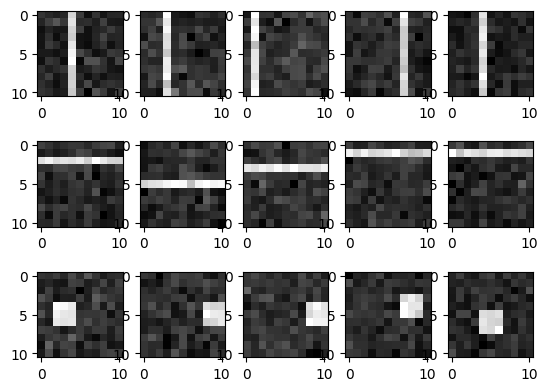

In [2]:
# set toy dataset image configuration
img_sz = 11
num_img_per_cls = 100
num_cls = 3
num_imgs = num_img_per_cls*num_cls
db_imgs = np.zeros((num_imgs,img_sz,img_sz))

ri_v = np.random.randint(img_sz-2, size=num_img_per_cls)
ri_h = np.random.randint(img_sz-2, size=num_img_per_cls)
re_sz = 3
ri_rp = np.random.randint(img_sz-4, size=(num_img_per_cls,2))
for i in range(num_img_per_cls):
    # class 0: vertical line at random position
    db_imgs[i,:,ri_v[i]+1] = 1
    # class 1: horizontal line at random position
    db_imgs[num_img_per_cls+i,ri_h[i]+1,:] = 1
    # class 1: horizontal line at random position
    db_imgs[num_img_per_cls*2+i,ri_rp[i,0]+2:ri_rp[i,0]+2+re_sz,ri_rp[i,1]+2:ri_rp[i,1]+2+re_sz] = 1

# add noise with normal distribution
noise_w = 0.1
db_imgs = db_imgs + noise_w*np.random.randn(num_cls*num_img_per_cls,img_sz,img_sz)

# visualize sample images
f, axarr = plt.subplots(3,5) 
for i in range(5):
    axarr[0,i].imshow(db_imgs[i,:,:],cmap='gray')
    axarr[1,i].imshow(db_imgs[num_img_per_cls+i,:,:],cmap='gray')
    axarr[2,i].imshow(db_imgs[num_img_per_cls*2+i,:,:],cmap='gray')
plt.show()

# construct labels
db_labels = np.zeros((num_cls*num_img_per_cls),dtype='int8')
db_labels[:num_img_per_cls] = 0
db_labels[num_img_per_cls:2*num_img_per_cls] = 1
db_labels[2*num_img_per_cls:] = 2

# pre-process sample images
db_data = db_imgs.copy()
# subtract mean
data_mean = np.mean(db_data)
db_data = db_data - data_mean

##### 문제1: Toy dataset - training/test 분할

다음 코드에서는 이전 문제에서 생성한 영상 DB를 임의로 학습용 training 데이터와 실험용 test 데이터로 분할한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

In [3]:
idxs = np.arange(num_img_per_cls)
np.random.shuffle(idxs)
tr_ratio = 0.8

num_tr_data = int(num_img_per_cls * tr_ratio)
tr_data = np.zeros((num_tr_data * num_cls, img_sz, img_sz))
tr_data[:num_tr_data, :] = db_data[idxs[:num_tr_data], :]
tr_data[num_tr_data:2 * num_tr_data, :] = db_data[num_img_per_cls + idxs[:num_tr_data], :]
tr_data[2 * num_tr_data:3 * num_tr_data, :] = db_data[2 * num_img_per_cls + idxs[:num_tr_data], :]

tr_labels = np.zeros((num_tr_data * num_cls), dtype='int8')
tr_labels[:num_tr_data] = 0  # 클래스 0 레이블
tr_labels[num_tr_data:2 * num_tr_data] = 1  # 클래스 1 레이블
tr_labels[2 * num_tr_data:3 * num_tr_data] = 2  # 클래스 2 레이블

num_te_data = num_img_per_cls - num_tr_data
te_data = np.zeros((num_te_data * num_cls, img_sz, img_sz))
te_data[:num_te_data, :] = db_data[idxs[num_tr_data:num_img_per_cls], :]
te_data[num_te_data:2 * num_te_data, :] = db_data[num_img_per_cls + idxs[num_tr_data:num_img_per_cls], :]
te_data[2 * num_te_data:3 * num_te_data, :] = db_data[2 * num_img_per_cls + idxs[num_tr_data:num_img_per_cls], :]

te_labels = np.zeros((num_te_data * num_cls), dtype='int8')
te_labels[:num_te_data] = 0  # 클래스 0 레이블
te_labels[num_te_data:2 * num_te_data] = 1  # 클래스 1 레이블
te_labels[2 * num_te_data:3 * num_te_data] = 2  # 클래스 2 레이블

print("data shape:", tr_data.shape)

data shape: (240, 11, 11)


##### 문제2: Convolutional neural network 모델의 local gradient 연산 정의

다음 코드는 아래 그림과 같이 1개의 hidden layer를 갖는 neural network의 객체를 정의하는 class의 코드이다.

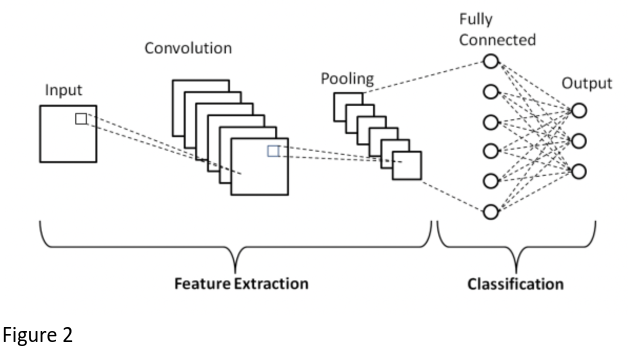

코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

In [4]:
class ConvNet2:
    def __init__(self, img_sz, k_sz, k_num, num_cls):
        # img_sz is tuple of image width and height (w,h) 
        self.img_sz = img_sz
        self.kernel_sz = k_sz
        self.kernel_num = k_num
        self.num_cls = num_cls
        # kernel parameters for convolutional neurons
        self.K1 = 0.001 * np.random.randn(k_sz, k_sz, k_num)
        self.b1 = np.zeros(k_num)
        # compute the dimension of convolutional output
        self.K_outdim = (self.img_sz - k_sz + 1) * (self.img_sz - k_sz + 1) * k_num
        # parameters for fully connected (linear) layer
        self.W2 = 0.001 * np.random.randn(self.K_outdim, num_cls)
        self.b2 = np.zeros(num_cls)
        self.scores = np.zeros(num_cls)
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        data = np.squeeze(data, axis=1)
        self.data = data
        self.batch_size = data.shape[0]
        self.conv_output = np.zeros((self.batch_size, self.kernel_num, self.img_sz - self.kernel_sz + 1, self.img_sz - self.kernel_sz + 1))
        for b in range(self.batch_size):
            for k in range(self.kernel_num):
                kernel = self.K1[:, :, k]
                for i in range(self.img_sz - self.kernel_sz + 1):
                    for j in range(self.img_sz - self.kernel_sz + 1):
                        self.conv_output[b, k, i, j] = np.sum(data[b, i:i+self.kernel_sz, j:j+self.kernel_sz] * kernel) + self.b1[k]
        relu_output = np.maximum(0, self.conv_output)
        self.fc_input = relu_output.reshape(self.batch_size, -1)
        self.scores = np.dot(self.fc_input, self.W2) + self.b2
        return self.scores
    def backward(self, upstream_grad):
        grad_W2 = np.dot(self.fc_input.T, upstream_grad)
        grad_b2 = np.sum(upstream_grad, axis=0)
        grad_relu = np.dot(upstream_grad, self.W2.T)
        grad_relu[self.fc_input <= 0] = 0
        grad_K1 = np.zeros_like(self.K1)
        grad_b1 = np.zeros_like(self.b1)
        grad_conv_output = grad_relu.reshape(self.conv_output.shape)
        for b in range(self.batch_size):
            for k in range(self.kernel_num):
                for i in range(self.img_sz - self.kernel_sz + 1):
                    for j in range(self.img_sz - self.kernel_sz + 1):
                        grad_K1[:, :, k] += self.data[b, i:i+self.kernel_sz, j:j+self.kernel_sz] * grad_conv_output[b, k, i, j]
                        grad_b1[k] += grad_conv_output[b, k, i, j]
        grad = {'K1': grad_K1, 'b1': grad_b1, 'W2': grad_W2, 'b2': grad_b2}
        return grad
    def grad_descent(self, grad, lr):
        grad_K1 = grad['K1']
        grad_b1 = grad['b1']
        self.K1 = self.K1 - lr*grad_K1
        self.b1 = self.b1 - lr*grad_b1
        grad_W2 = grad['W2']
        grad_b2 = grad['b2']
        self.W2 = self.W2 - lr*grad_W2
        self.b2 = self.b2 - lr*grad_b2
    def visualize_kernels(self):
        f, axarr = plt.subplots(self.kernel_num)
        for j in range(self.kernel_num):
            axarr[j].imshow(self.K1[j,:,:],cmap='gray')
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W2.shape[0]))
        for j in range(self.num_cls):
            axarr[j].imshow(self.W2[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 문제3: Softmax loss 함수의 local gradient 연산 정의

다음 코드는 Softmax 함수 기반의 cross-entropy loss 함수와 이를 기준으로 모델을 학습하는데 필요한 gradient를 계산하는 과정을 포함한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.
[아울러 SoftMaxLoss 클래스의 compute_grad 함수의 경우 아래 구현된 코드를 바탕으로 softmax 함수에 대해 정의된 multi-layer perceptron 구조의 신경망의 gradient의 수식 등을 포함한 이론을 정리하여 제시하라. 제공된 결과보고서 파일에 개별 챕터로 정리하여 제출한다.]

In [5]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.data = 0
        self.probs = 0
        self.num_cls = num_cls
    def compute_probs(self, data):
        scores = self.model.forward(data)
        self.model_scores = scores
        scores -= np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs
    def compute_loss(self, data, labels):
        self.data = data
        self.labels = labels
        probs = self.compute_probs(data)
        self.probs = probs
        epsilon = 1e-10
        correct_log_probs = -np.log(probs[np.arange(data.shape[0]), labels] + epsilon)
        loss = np.sum(correct_log_probs) / data.shape[0]
        self.loss = loss
        return self.loss
    def compute_grad(self):
        # consider score dimensions
        z = self.probs
        # consider grad_z dimensions (should be same as z dim)
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
        return self.model.backward(grad_z)


##### 문제4: Gradient descent 알고리즘 구현

다음 코드는 gradient descent 알고리즘으로 학습 데이터에 대해 MLP neural network를 학습하는 코드이다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

loss= 1.0986062851258904
loss= 1.098793515480331
loss= 1.0985219901370393
loss= 1.099147471914029
loss= 1.0986539179663033
loss= 1.0988506853266022
loss= 1.097938241636235
loss= 1.0984561674922184
loss= 1.0995300173604352
loss= 1.0999089447640018
loss= 1.0989665982645351
loss= 1.09842710684346
loss= 1.0979042497645004
loss= 1.0991416135398238
loss= 1.0991716762771726
loss= 1.0991850962346343
loss= 1.0979295959739808
loss= 1.0985682181325558
loss= 1.0982929298459454
loss= 1.0984307630059058
loss= 1.0967571465684012
loss= 1.1008210055024525
loss= 1.0971299296219335
loss= 1.1014087639468293
loss= 1.10223959578129
loss= 1.0989226907224754
loss= 1.098469412781845
loss= 1.0980694911400413
loss= 1.0984752247432636
loss= 1.0975649459818557
loss= 1.0971666282844437
loss= 1.09915506180447
loss= 1.0982723554106384
loss= 1.0968620840560352
loss= 1.0996253687720217
loss= 1.0987845125674651
loss= 1.097015536830652
loss= 1.0977832133268959
loss= 1.097459353610688
loss= 1.0984223544455485
loss= 1.1004

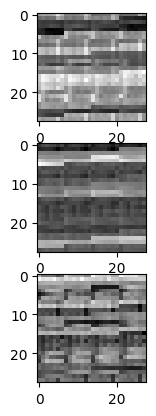

In [6]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    batch_indices = np.random.choice(num_data, batch_sz)
    batch_data = db_data[batch_indices]
    batch_labels = db_labels[batch_indices]
    return batch_data, batch_labels

def train_convnet2(db_data, db_labels, num_cls, lr, batch_sz, num_iter, kernel_sz, kernel_num):
    # define & initialize MLP neural network classifier
    db_data = db_data.reshape(db_data.shape[0], 1, db_data.shape[1], db_data.shape[2])
    num_data = db_data.shape[0]
    img_sz = db_data.shape[2]
    model = ConvNet2(img_sz, kernel_sz, kernel_num, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad()
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 0.001
batch_sz = 128
num_iter = 200
kernel_sz = 5
kernel_num = 16

model = train_convnet2(tr_data, tr_labels, num_cls, lr, batch_sz, num_iter, kernel_sz, kernel_num)


##### 문제5: 학습된 모델을 이용한 test data classification

다음 코드에서는 학습된 ConvNet2를 이용하여 테스트 데이터의 판별 결과를 도출한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

다양한 실험을 통해 learning rate, batch size, number of hidden neuron 값을 다양하게 조정해 가며 Accuracy를 최대한 높게 만들어 보고, 이 과정의 세부 내용을 보고서에 명시하여라.

In [8]:
if te_data.ndim == 3:
    te_data = te_data.reshape(te_data.shape[0], 1, te_data.shape[1], te_data.shape[2])
te_scores = model.forward(te_data)
predicted_labels = np.argmax(te_scores, axis=1)
correct_predictions = np.sum(predicted_labels == te_labels)
total_predictions = te_labels.shape[0]
Acc = correct_predictions / total_predictions
print('Classification accuracy=', Acc)


Classification accuracy= 1.0
